# Diabetes Feature Engineering

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

- Pregnancies: Hamilelik sayısı
- Glucose: Glikoz
- BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
- SkinThickness: Cilt Kalınlığı
- Insulin: İnsülin.
- BMI: Beden kitle indeksi.
- DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
- Age: Yaş (yıl)
- Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("./diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# EDA

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Info #####################")
    print(dataframe.info())

In [4]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

- Veri seti 768 satır ve 9 sütundan oluşmaktadır.
- Veri setinde tüm değişkenlerin sayısal olduğu görülmektedir.
- Veri setinde eksik değer görülmemektedir.
- Veri seti hafızada yaklaşık 54.1 KB yer tutmaktadır.


### Determine Data Types

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


- Veri setinde  1 adet kategorik ve 8 adet nümerik değişken bulunmaktadır. Kategorik değişken, 'Outcome' hedef değişkenidir.

In [7]:
print(f'Categorical Variables:\n{cat_cols}')
print(f'\nNumerical Variables:\n{num_cols}')
print(f'\nCategorical but Cardinal:\n{cat_but_car}')

Categorical Variables:
['Outcome']

Numerical Variables:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Categorical but Cardinal:
[]


#### Analysis of Categorical Variables

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


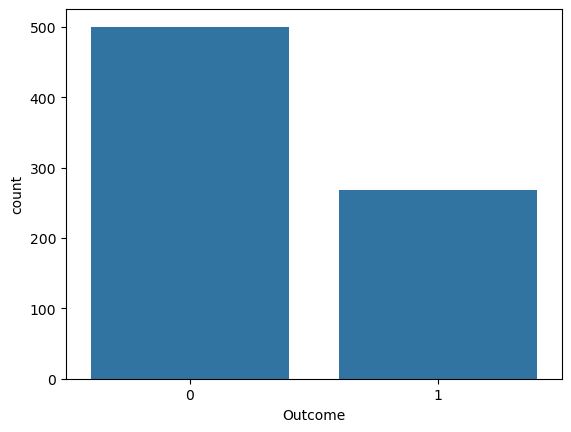

In [9]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

- `Outcome` değişkeninde dağılım olarak yarı yarıya bir oran gözlemlenmiştir.
- **Hasta olmayanların** sayısı **500** ile **%65** oranındadır.
- **Hasta olanların** sayısı **268** ile **%35** oranındadır.

#### Analysis of Numerical Variables

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


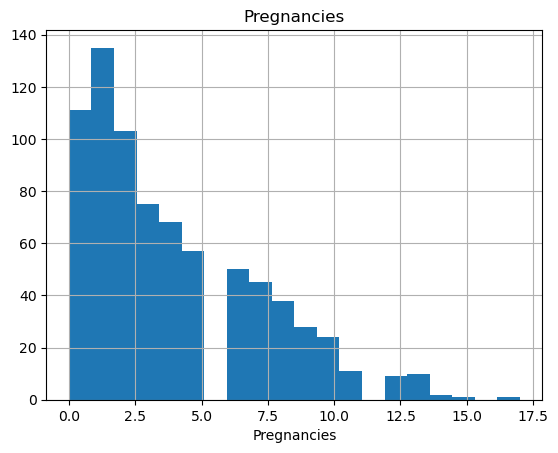

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


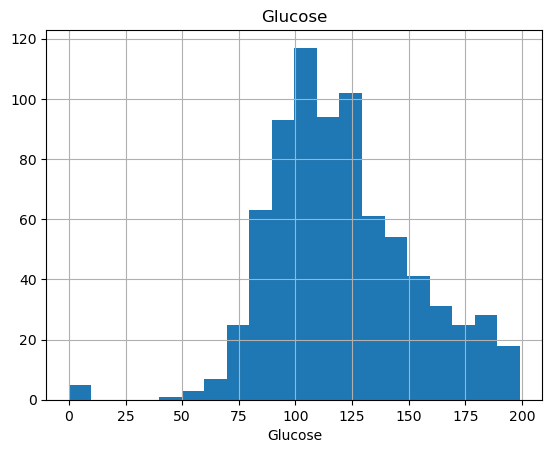

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


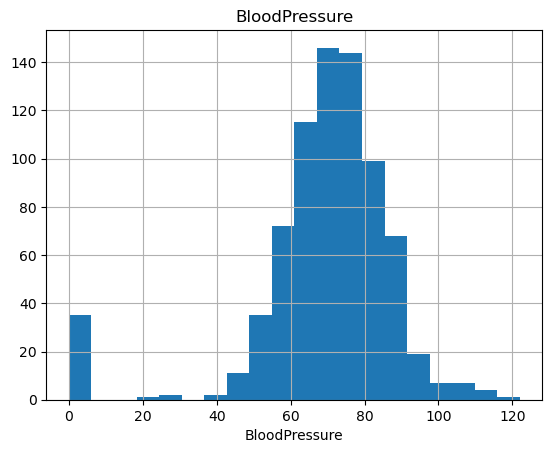

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


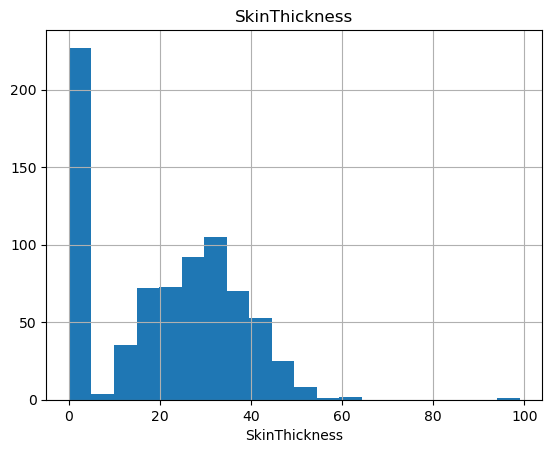

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


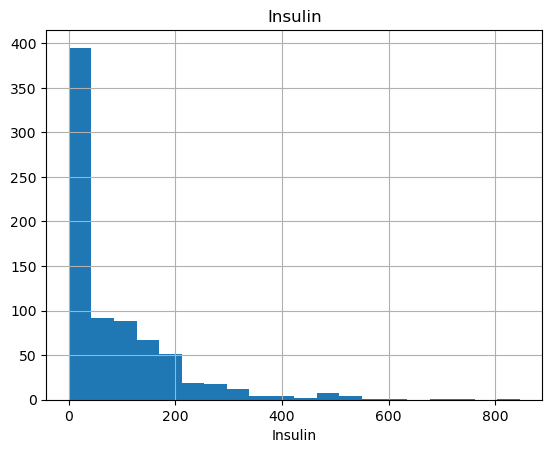

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


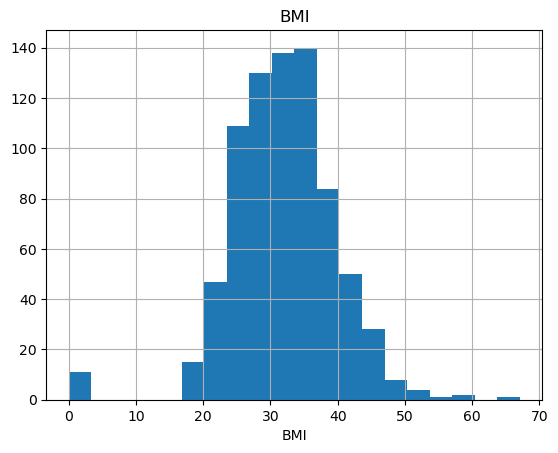

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


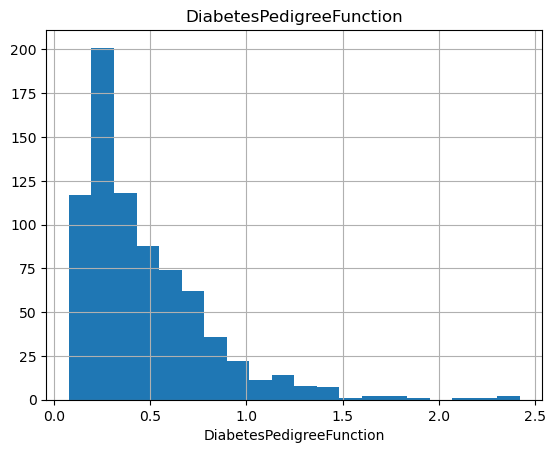

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


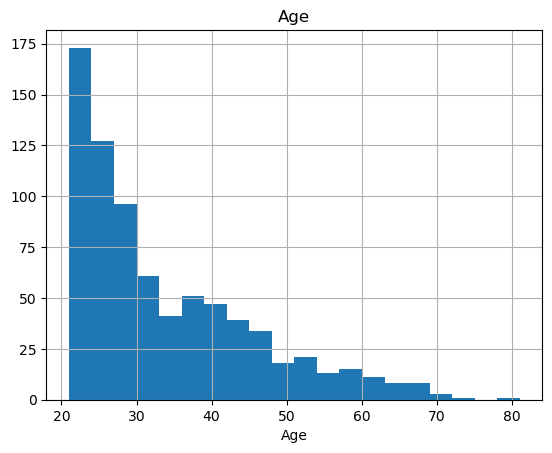

In [11]:
for col in num_cols:
    num_summary(df, col, plot=True)

#### Analysis of Numerical Variables with Target Variable

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [13]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




- **Diyabet olan** kişilerin hamilelik sayısı ortalaması daha yüksektir.
- **Diyabet olan** kişilerin glükoz değerleri ortalaması daha yüksektir (141).
- **Diyabet olan ve olmayanların** kan basıncı değerlerinde gözle görülür çok fark yoktur.
- **Diyabet olan** kişilerin deri kalınlıkları ortalaması daha kalındır.
- **Diyabet olan** kişilerin insülin değeri ortalaması daha yüksektir (100).
- **Diyabet olan** kişilerin BMI ortalaması daha yüksektir (35).
- **Diyabet olanların** soylarında diyabet olana göre hesaplanan fonksiyon değeri ortalaması daha yüksektir.
- **Diyabet olanların** yaş ortalaması daha yüksektir (37).

## Korelasyon Analizi

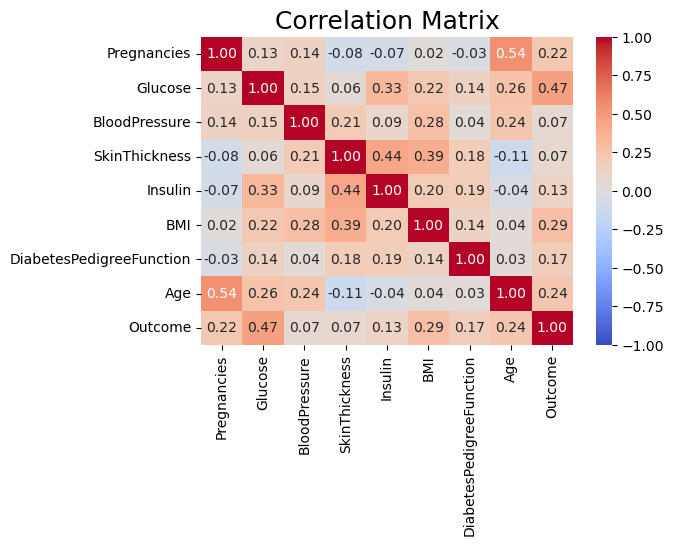

In [14]:
df.corr()

f, ax = plt.subplots(figsize=[6, 4])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="coolwarm", center=0 ,vmax=1,vmin=-1)
ax.set_title("Correlation Matrix", fontsize=18)
plt.show()

### 1. Hedef Değişken (Outcome) ile İlişkiler

* **Glucose (0.47):** Hedef değişken ile en güçlü pozitif korelasyona sahip özelliktir. Kandaki glikoz seviyesi arttıkça diyabet olma olasılığı belirgin şekilde artmaktadır.
* **BMI (0.29):** Vücut Kitle İndeksi, diyabet sonucu ile orta düzeyde pozitif bir ilişkiye sahiptir.
* **Age (0.24) ve Pregnancies (0.22):** Yaş ve hamilelik sayısı, diyabet sonucu ile benzer seviyede pozitif bir ilişki göstermektedir.
* **Zayıf İlişkiler:** `BloodPressure` (0.07) ve `SkinThickness` (0.07) değişkenlerinin, tek başlarına diyabet sonucu üzerinde ayırt edici etkisi oldukça düşüktür.

### 2. Değişkenler Arası İlişkiler

* **Pregnancies & Age (0.54):** Matristeki **en yüksek korelasyon** bu iki değişken arasındadır. Yaş ilerledikçe hamilelik sayısının artması beklenen bir durumdur.
* **SkinThickness & Insulin (0.44):** Deri kalınlığı ile insülin seviyesi arasında anlamlı bir pozitif ilişki vardır.
* **SkinThickness & BMI (0.39):** Vücut kitle indeksi arttıkça deri kalınlığının artması, fiziksel olarak tutarlı bir ilişkidir.
* **Glucose & Insulin (0.33):** Glikoz ve insülin arasındaki biyolojik mekanizma gereği orta düzeyde bir ilişki gözlemlenmiştir.

### 3. Negatif ve Nötr İlişkiler

* **Age & SkinThickness (-0.11):** Veri setindeki en belirgin negatif ilişki buradadır. Yaş ilerledikçe deri kalınlığında çok hafif bir azalma eğilimi görülmektedir.

### 4. Sonuç ve Öneriler
1. **Modelleme:** Diyabet tahminlemesi yapılacak bir makine öğrenmesi modelinde `Glucose` en önemli öznitelik (feature) olacaktır.
2. **Öznitelik Seçimi:** `SkinThickness` ve `BloodPressure` değişkenlerinin hedef değişkenle ilişkisi çok düşük (0.07) olduğu için, model başarısını artırmak adına bu değişkenlerin katkısı sorgulanabilir veya dönüştürülerek kullanılabilir.

## Base Model

In [15]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}") # Pozitif sınıfın ne kadar başarılı tahmin edildiği
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}") # Pozitif sınıf olarak tahmin edilen değerlerin başarısı
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


- Henüz feature engineering & data preprocessing yapılmadan base model 'RandomForestClassifier' modeli ile kurulmuştur.

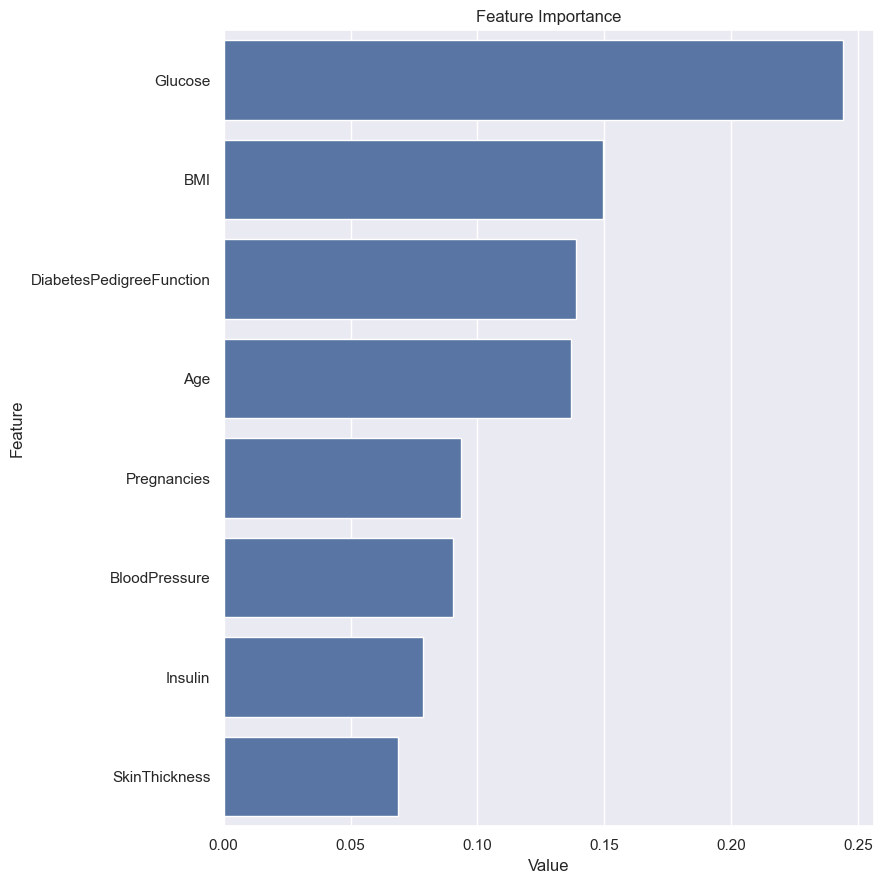

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9, 9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

- Base modele göre en önemli özellik **Glikoz** değişkenidir. Ardından **BMI** değişkeni gelmektedir.

# Feature Engineering

## Missing Value Analysis

In [17]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamaz.
# Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir.

zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [18]:
# Gözlem birimlerinde 0 olan değişkenlerin her birisine gidip 0 içeren değerleri NaN ile değiştirmeliyiz.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [19]:
# Eksik Gözlem Analizi
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [20]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [21]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [22]:
# Eksik Değerlerin Median değeri ile Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

In [23]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

- Artık eksik değerler veri setimizde bulunmuyor.

## Outlier Analysis

In [24]:
# Gerekli fonksiyonlarımızı tanımlayalım
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [25]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


- Outlier değer olan değişkenler:
    - SkinThickness
    - Insulin

In [26]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


- Artık outlier değerlerden kurtulduk.

## Feature Extraction

In [27]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

- Burada Yaş değişkeninden belirli aralıklar belirleyip "NEW_AGE_CAT" adında yeni bir değişken oluşturulmuştur. Bu değişken yaşa göre mature (olgun), senior (yaşlı) sınıflarını içermektedir.

In [28]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

- BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez olmak üzere yeni "NEW_BMI" değişkeni oluşturulmuştur.

In [29]:
# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

- Glükoz değerinin aralıkları belirlenerek, "NEW_GLUCOSE" adında yeni değişken oluşturulmuştur.

In [30]:
# # Yaş ve BMI bir arada düşünerek kategorik değişken oluşturma.
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

- Burada Yaş ve BMI değişkeni birlikte kullanılarak çeşitli aralıklarda tanımlamalar yapıldı ve kategorik değişken olarak "NEW_AGE_BMI_NOM" değişkeni oluşturulmuştur.

In [31]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

- Burada Yaş ve Glikoz değişkeni birlikte kullanılarak çeşitli aralıklarda tanımlamalar yapıldı ve kategorik değişken olarak "NEW_AGE_GLUCOSE_NOM" değişkeni oluşturulmuştur.

In [32]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

- Burada insülin değerlerine göre literatür taramasından aralıklar belirlendi ve "NEW_INSULIN_SCORE" değişkeni oluşturuldu. 

In [33]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

- Glikoz ve Insulin değişkeni arasındaki ilişkiyi incelemek adına yeni "NEW_GLUCOSE*INSULIN" değişkeni oluşturuldu.

In [34]:
# sıfır olan değerler dikkat!!!!
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]
#df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])

- Glikoz ve Hamilelik değişkeni arasındaki ilişkiyi incelemek adına yeni "NEW_GLUCOSE*PREGNANCIES" değişkeni oluşturuldu.

In [35]:
# Kolon isimlerinin büyültülmesi.
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


In [36]:
df.shape

(768, 17)

## Encoding

In [37]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


- Tekrardan değişken tiplerini belirlemek adına fonksiyonu tekrar çağırıyoruz.

### Label Encoding

In [38]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

for col in binary_cols:
    df = label_encoder(df, col)

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']


- Türü kategorik olan ve özgün değişken sayısı 2 olan değişkenler burada **'NEW_AGE_CAT'** ve **'NEW_INSULIN_SCORE'** değişkenleridir. Bu değişkenler binary (ikili) olarak sınıflandırıldı ve bu değişkenlere "Label Encoding" işlemi uygulanmıştır.

In [39]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


## One-Hot Encoding

In [40]:
# One-Hot Encoding
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [41]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [42]:
df.shape

(768, 27)

## Standard Scaling

In [44]:
print(num_cols)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_GLUCOSE*INSULIN', 'NEW_GLUCOSE*PREGNANCIES']


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [45]:
df.shape

(768, 27)

- Numerik değişkenlere standardizasyon işlemi uygulanmıştır. 

# Machine Learning


In [47]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


- **Base Model Skorları**
    - Accuracy: 0.77
    - Recall: 0.706
    - Precision: 0.59
    - F1: 0.64
    - Auc: 0.75

Görüldüğü üzere feature engineering uygulamasından sonra Base Modele göre skorlarda gözle görülür bir şekilde artış gözlemlenmiştir.

## Feature Importance

    Value                            Feature
1   0.139                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
5   0.099                                BMI
11  0.098            NEW_GLUCOSE*PREGNANCIES
7   0.097                                AGE
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


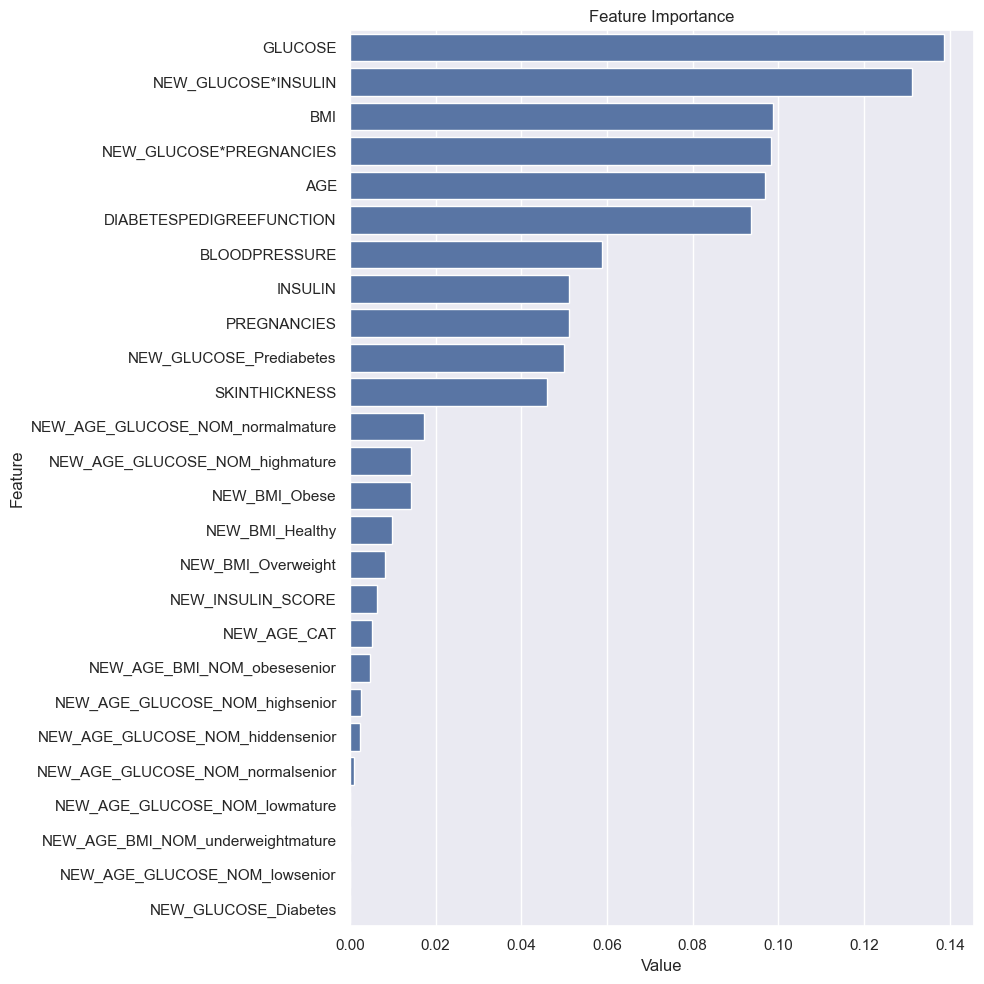

In [50]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

- Değişken önem sırasında glikoz değişkeninden sonra feature engineering aşamasında oluşturulan "NEW_GLUCOSE*INSULIN" değişkeni gelmektedir.